# Domain Uncertainty

## In Domain Uncertainty
In-domain uncertainty represents the uncertainty related to inputs drawn from a distribution believed to be equal to the training data distribution. Thus, any uncertainty from in-domain inputs result from our model's inability to properly understand an in-domain sample, indicating a design error in our model choice (model uncertainty), or the complexity of the problem (data uncertainty). In this tutorial we train on all the numbers, establishing numbers 0-9 as "in domain", and test on those same numbers to show in domain uncertainty.

[1]

In [1]:
import torch
import copy
import os
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from experiments.nns.bdl import SelectMNISTDataset

# Define the path to directory containing MNIST
mnist_directory = os.path.abspath(os.path.join(os.path.dirname(os.path.abspath("uncertainty.ipynb")), "..","..","..","..","..","..","..", "/usr/data1/vision/data/"))


# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the MNIST training dataset
# def __init__(self, root, numbers=[0, 1], train=False, transform=None, limit=None):
train_dataset = SelectMNISTDataset(root=mnist_directory, train=True, numbers = [0,1,2,3,4,5,6,7,8,9], num_entries_per_digit=10, transform=transform)

In [2]:
import torch
from torch.utils.data import DataLoader
import push.bayes.ensemble
from experiments.nns.lenet.lenet import LeNet


# Create data loaders
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
epochs = 50

ensemble = push.bayes.ensemble.train_deep_ensemble(
        train_loader,
        torch.nn.CrossEntropyLoss(),
        epochs,
        LeNet,
        num_devices=2,
        num_ensembles=100,
        cache_size=25
    )

100%|██████████| 50/50 [03:51<00:00,  4.62s/it, loss=tensor(0.1284)]


In [3]:
test_dataset = SelectMNISTDataset(root=mnist_directory, train=True, numbers = [0,1,2,3,4,5,6,7,8,9], num_entries_per_digit=1, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [4]:
outputs = ensemble.posterior_pred(test_loader, f_reg=False, mode=["mode","logits", "prob", "std"])

In [5]:
# Display rotated images
# num_images_to_display = 
idx_image_to_display = 10
i = 0
for images, labels in test_loader:
    img = images
    lbl = labels
    i += 1
    if i == idx_image_to_display:
        break

Trained on all numbers, testing on 9

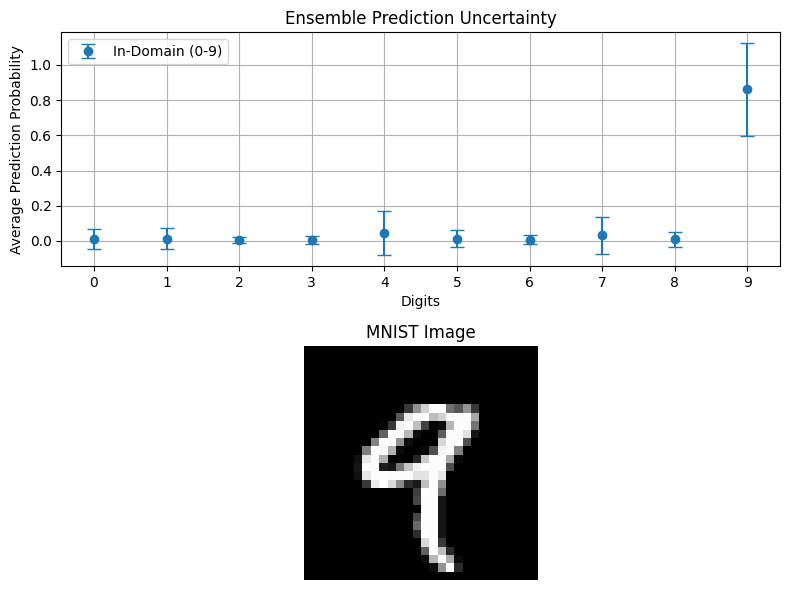

In [6]:
import numpy as np
import matplotlib.pyplot as plt
# Sample average prediction probabilities and standard deviations
digits = np.arange(10)  # Digits 0-9
# avg_probs = np.array([0.92, 0.91, 0.93, 0.94, 0.92, 0.95, 0.94, 0.92, 0.93, 0.6])  # Sample average probs
# std_devs = np.array([0.03, 0.02, 0.03, 0.02, 0.03, 0.02, 0.03, 0.03, 0.03, 0.1])  # Sample std devs
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
# Plotting
plt.errorbar(digits, torch.mean(outputs["prob"], dim=1).squeeze()[9], yerr=outputs["std"][9], fmt='o', capsize=5, label='In-Domain (0-9)')
# plt.scatter(9, 0.6, color='red', label='Out-of-Domain (9)')

plt.xticks(digits)
plt.xlabel('Digits')
plt.ylabel('Average Prediction Probability')
plt.title('Ensemble Prediction Uncertainty')
plt.legend()
plt.grid(True)

# Second subplot for the MNIST image
plt.subplot(2, 1, 2)
plt.imshow(img.squeeze(), cmap='gray')
plt.axis('off')  # Remove axis
plt.title('MNIST Image')

# Adjust layout to prevent overlapping titles
plt.tight_layout()
plt.show()

## Out of Domain Uncertainty
Out of domain uncertainty represents the uncertainty related to inputs drawn from the subspace of unknown data. In this tutorial we examine the MNIST dataset, and train on set of numbers 1-8, establishing our "in-domain" as the numbers 1-8. By testing on the number 9, an out of domain input, we can determine how uncertain our model is when encountering data it is not equipped to handle.

[1]

### Dataset

In [7]:
import torch
import copy
import os
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from experiments.nns.bdl import SelectMNISTDataset

# Define the path to directory containing MNIST
mnist_directory = os.path.abspath(os.path.join(os.path.dirname(os.path.abspath("uncertainty.ipynb")), "..","..","..","..","..","..","..", "/usr/data1/vision/data/"))


# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the MNIST training dataset
# def __init__(self, root, numbers=[0, 1], train=False, transform=None, limit=None):
train_dataset = SelectMNISTDataset(root=mnist_directory, train=True, numbers = [0,1,2,3,4,5,6,7,8], num_entries_per_digit=10, transform=transform)

In [8]:
import torch
from torch.utils.data import DataLoader
import push.bayes.ensemble
from experiments.nns.lenet.lenet import LeNet


# Create data loaders
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
epochs = 50

ensemble = push.bayes.ensemble.train_deep_ensemble(
        train_loader,
        torch.nn.CrossEntropyLoss(),
        epochs,
        LeNet,
        num_devices=2,
        num_ensembles=100,
        cache_size=25
    )

100%|██████████| 50/50 [03:49<00:00,  4.59s/it, loss=tensor(0.4462)]


In [9]:
test_dataset = SelectMNISTDataset(root=mnist_directory, train=True, numbers = [0,1,2,3,4,5,6,7,8,9], num_entries_per_digit=1, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [10]:
outputs = ensemble.posterior_pred(test_loader, f_reg=False, mode=["mode","logits","prob", "std"])


Trained on numbers 0-8, testing on number 9 image

In [11]:
# Display rotated images
# num_images_to_display = 
idx_image_to_display = 10
i = 0
for images, labels in test_loader:
    img = images
    lbl = labels
    i += 1
    if i == idx_image_to_display:
        break

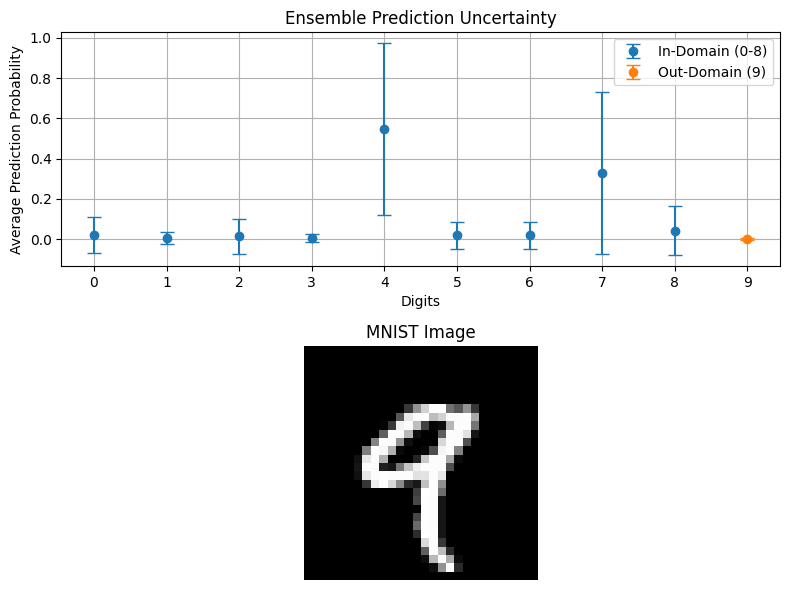

In [17]:
import numpy as np
import matplotlib.pyplot as plt
# Sample average prediction probabilities and standard deviations
# digits = np.arange(10)  # Digits 0-9
plt.figure(figsize=(8, 6))
digits = np.arange(10)
# avg_probs = np.array([0.92, 0.91, 0.93, 0.94, 0.92, 0.95, 0.94, 0.92, 0.93, 0.6])  # Sample average probs
# std_devs = np.array([0.03, 0.02, 0.03, 0.02, 0.03, 0.02, 0.03, 0.03, 0.03, 0.1])  # Sample std devs
plt.subplot(2, 1, 1)
# Plotting
plt.errorbar(digits[:-1], torch.mean(outputs["prob"], dim=1).squeeze()[9][:-1], yerr=outputs["std"][9][:-1], fmt='o', capsize=5, label='In-Domain (0-8)')
plt.errorbar(9, torch.mean(outputs["prob"], dim=1).squeeze()[9][-1], yerr=outputs["std"][9][-1], fmt='o', capsize=5, label='Out-Domain (9)')
# plt.scatter(9, 0.6, color='red', label='Out-of-Domain (9)')

plt.xticks(digits)
plt.xlabel('Digits')
plt.ylabel('Average Prediction Probability')
plt.title('Ensemble Prediction Uncertainty')
plt.legend()
plt.grid(True)


# Second subplot for the MNIST image
plt.subplot(2, 1, 2)
plt.imshow(img.squeeze(), cmap='gray')
plt.axis('off')  # Remove axis
plt.title('MNIST Image')

# Adjust layout to prevent overlapping titles
plt.tight_layout()

plt.show()

We can see that the model's most probable prediction (4) has a very high degree of uncertainty, demonstrated by its very large standard deviation.

References 

[1] Gawlikowski, J., Njieutcheu Tassi, C. R., Ali, M., Lee, J., Humt, M., Feng, J., Kruspe, A., Triebel, R., Jung, P., Roscher, R., Shahzad, M., Yang, W., Bamler, R., & Zhu, X. X. (2022). A Survey of Uncertainty in Deep Neural Networks. arXiv preprint arXiv:2107.03342.